Hunter Bennett | Glass Lab | Kupffer Strains Project | 11 April 2023

Maggie analysis of differentially accessible ATAC-seq peaks using low/equal/high basal peak segregation

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

Set working directory

In [2]:
workingDirectory = '/home/h1bennet/strains_github/results/Figure6/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [3]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

Import files with categorization of peaks into basal status

In [4]:
df = pd.read_csv('https://zenodo.org/record/7829622/files/atac_balbcj_basal_status.csv', index_col=0)
df.to_csv('./atac_balbcj_basal_status.txt', sep='\t')

df = pd.read_csv('https://zenodo.org/record/7829622/files/atac_c57bl6j_basal_status.csv', index_col=0)
df.to_csv('./atac_c57bl6j_basal_status.txt', sep='\t')

### Create peak files for input into MAGGIE

In [5]:
if not os.path.isdir('./differential_peaks/'):
    os.mkdir('./differential_peaks/')

#### BALB/cJ

Import segregated peak file

In [6]:
balb = pd.read_csv('./atac_balbcj_basal_status.txt', sep='\t', index_col=0)
balb.index.rename('PeakID', inplace=True)

Resize peaks to 200bp

In [7]:
keeper_cols = ['Chr', 'Start', 'End', 'Strand', 'Basal accessibility']
new_start = []
new_end = []
for index, row in balb.iterrows():
    center = row.Start + int(np.floor((row.End - row.Start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
balb_200bp = balb.loc[:, keeper_cols].copy(deep=True)
balb_200bp['Start'] = new_start
balb_200bp['End'] = new_end
balb_200bp.index.rename('PeakID', inplace=True)
balb_200bp.reset_index(inplace=True)

Separate into groups and save

In [8]:
for i in ['Equal basal', 'High basal', 'Low basal']:
    balb_200bp_filt = balb_200bp.loc[balb_200bp.loc[:, 'Basal accessibility'] == i, :]
    balb_200bp_filt.iloc[:, :5].to_csv('./differential_peaks/balbcj_'+i.replace(' ', '_')+'.txt',
                                       sep='\t', index=False)

### C57

Import segregated peak file

In [9]:
c57 = pd.read_csv('./atac_c57bl6j_basal_status.txt', sep='\t', index_col=0)
c57.index.rename('PeakID', inplace=True)

Resize peaks to 200bp

In [10]:
bpkeeper_cols = ['Chr', 'Start', 'End', 'Strand', 'Basal accessibility']
new_start = []
new_end = []
for index, row in c57.iterrows():
    center = row.Start + int(np.floor((row.End - row.Start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
c57_200bp = c57.loc[:, keeper_cols].copy(deep=True)
c57_200bp['Start'] = new_start
c57_200bp['End'] = new_end
c57_200bp.index.rename('PeakID', inplace=True)
c57_200bp.reset_index(inplace=True)

Separate into groups and save

In [11]:
for i in ['Equal basal', 'High basal', 'Low basal']:
    c57_200bp_filt = c57_200bp.loc[c57_200bp.loc[:, 'Basal accessibility'] == i, :]
    c57_200bp_filt.iloc[:, :5].to_csv('./differential_peaks/c57bl6j_'+i.replace(' ', '_')+'.txt',
                                       sep='\t', index=False)

#### Aside: generate pie chart describing relative proportion of basal regulatoin categories across ATAC-seq peaks

In [12]:
!wc -l ./differential_peaks/*basal.txt

  659 ./differential_peaks/balbcj_Equal_basal.txt
  131 ./differential_peaks/balbcj_High_basal.txt
   32 ./differential_peaks/balbcj_Low_basal.txt
  407 ./differential_peaks/c57bl6j_Equal_basal.txt
  211 ./differential_peaks/c57bl6j_High_basal.txt
   27 ./differential_peaks/c57bl6j_Low_basal.txt
 1467 total


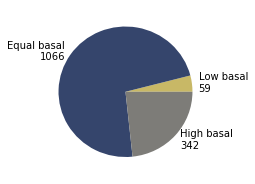

In [13]:
# quick pie chart of relative size of groups
equal_basal = 659+407
high_basal = 131+211
low_basal = 32+27

labels = ['Low basal\n%i' % low_basal, 'Equal basal\n%i' % equal_basal, 'High basal\n%i' % high_basal]
sizes = [low_basal, equal_basal, high_basal]
explode = (0, 0, 0)
pal = matplotlib.cm.get_cmap('cividis')
colors = [pal(0.8), pal(0.2), pal(0.5)]

fig, ax = plt.subplots(figsize=(3,3))
ax.pie(sizes, labels=labels, colors=colors, explode=explode);

### Extract sequences for maggie

In [14]:
if not os.path.isdir('./differential_fasta/'):
    os.mkdir('./differential_fasta/')

### BALB/cJ Specific peaks

#### Low basal  

    MMARGE.pl extract_sequences -ind BALBCJ \
    -file ./differential_peaks/balbcj_Low_basal.txt \
    -output ./differential_fasta/balbcj_Low_basal_ref_200bp.fa
    
    MMARGE.pl extract_sequences -ind C57BL6J \
    -file ./differential_peaks/balbcj_Low_basal.txt \
    -output ./differential_fasta/balbcj_Low_basal_mut_200bp.fa

#### Equal basal  

    MMARGE.pl extract_sequences -ind BALBCJ \
    -file ./differential_peaks/balbcj_Equal_basal.txt \
    -output ./differential_fasta/balbcj_Equal_basal_ref_200bp.fa  
    
    MMARGE.pl extract_sequences -ind C57BL6J \
    -file ./differential_peaks/balbcj_Equal_basal.txt \
    -output ./differential_fasta/balbcj_Equal_basal_mut_200bp.fa

#### High basal   

    MMARGE.pl extract_sequences -ind BALBCJ \
    -file ./differential_peaks/balbcj_High_basal.txt \
    -output ./differential_fasta/balbcj_High_basal_ref_200bp.fa  
    
    MMARGE.pl extract_sequences -ind C57BL6J \
    -file ./differential_peaks/balbcj_High_basal.txt \
    -output ./differential_fasta/balbcj_High_basal_mut_200bp.fa



### C57BL/6J Specific peaks

#### Low basal  

    MMARGE.pl extract_sequences -ind C57BL6J \
    -file ./differential_peaks/c57bl6j_Low_basal.txt \
    -output ./differential_fasta/c57bl6j_Low_basal_ref_200bp.fa  

    MMARGE.pl extract_sequences -ind BALBCJ \
    -file ./differential_peaks/c57bl6j_Low_basal.txt \
    -output ./differential_fasta/c57bl6j_Low_basal_mut_200bp.fa

####  Equal basal  

    MMARGE.pl extract_sequences -ind C57BL6J \
    -file ./differential_peaks/c57bl6j_Equal_basal.txt \
    -output ./differential_fasta/c57bl6j_Equal_basal_ref_200bp.fa  
    
    MMARGE.pl extract_sequences -ind BALBCJ \
    -file ./differential_peaks/c57bl6j_Equal_basal.txt \
    -output ./differential_fasta/c57bl6j_Equal_basal_mut_200bp.fa

#### High basal  

    MMARGE.pl extract_sequences -ind C57BL6J \
    -file ./differential_peaks/c57bl6j_High_basal.txt \
    -output ./differential_fasta/c57bl6j_High_basal_ref_200bp.fa  
    
    MMARGE.pl extract_sequences -ind BALBCJ \
    -file ./differential_peaks/c57bl6j_High_basal.txt \
    -output ./differential_fasta/c57bl6j_High_basal_mut_200bp.fa


### Run MAGGIE

In [22]:
if not os.path.isdir('./maggie_output/'):
    os.mkdir('./maggie_output/')

####  Low basal

    /home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
    ./differential_fasta/balbcj_Low_basal_ref_200bp.fa,\
    ./differential_fasta/c57bl6j_Low_basal_ref_200bp.fa \
    ./differential_fasta/balbcj_Low_basal_mut_200bp.fa,\
    ./differential_fasta/c57bl6j_Low_basal_mut_200bp.fa \
    -o ./maggie_output/low_basal_200bp/ \
    -p 8
    
    /home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
    ./differential_fasta/balbcj_Equal_basal_ref_200bp.fa,\
    ./differential_fasta/c57bl6j_Equal_basal_ref_200bp.fa \
    ./differential_fasta/balbcj_Equal_basal_mut_200bp.fa,\
    ./differential_fasta/c57bl6j_Equal_basal_mut_200bp.fa \
    -o ./maggie_output/equal_basal_200bp/ \
    -p 8
    
    /home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
    ./differential_fasta/balbcj_High_basal_ref_200bp.fa,\
    ./differential_fasta/c57bl6j_High_basal_ref_200bp.fa \
    ./differential_fasta/balbcj_High_basal_mut_200bp.fa,\
    ./differential_fasta/c57bl6j_High_basal_mut_200bp.fa \
    -o ./maggie_output/high_basal_200bp/ \
    -p 8

# Aggregate results MAGGIE

In [24]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*/maggie_output_merged.tsv'):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)

    # remove duplicates
    # frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.loc[:, 'Median p-val']

    # extract name of sample
    sample = f.split('/')[2]

    # store in dict
    maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_output/maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-10
filtered_frame = frame.loc[(np.abs(frame) > 1).any(1), :]

# replace NaN with 0
# filtered_frame = filtered_frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

filtered_frame.to_csv('./maggie_output/maggie_merged_motif_log10pvalues.txt',
                      sep='\t')

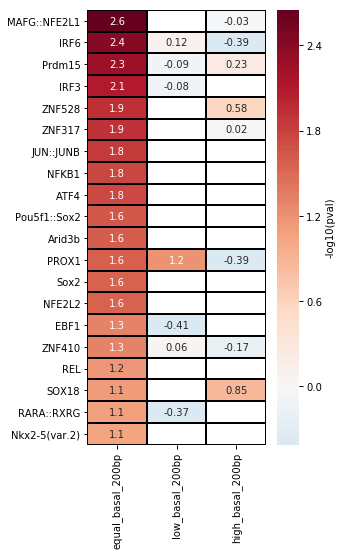

In [25]:
fig, ax = plt.subplots(figsize=(4,8))

filtered_frame = filtered_frame.sort_values('equal_basal_200bp', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, :].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

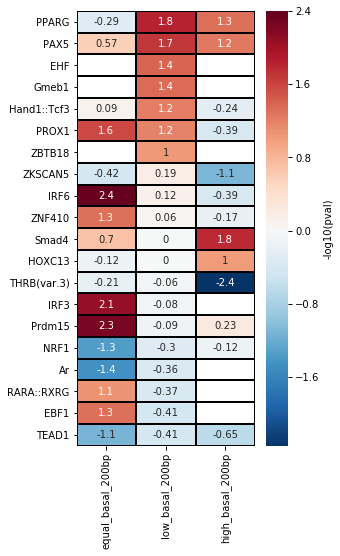

In [26]:
fig, ax = plt.subplots(figsize=(4,8))

filtered_frame = filtered_frame.sort_values('low_basal_200bp', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, :].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

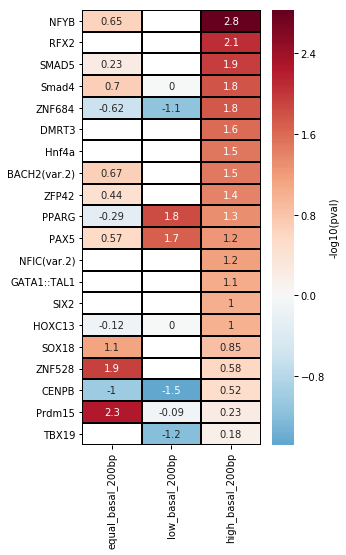

In [27]:
fig, ax = plt.subplots(figsize=(4,8))

filtered_frame = filtered_frame.sort_values('high_basal_200bp', ascending=False)

hm = sns.heatmap(
    filtered_frame.loc[:, :].iloc[:20, :],
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)